In [1]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 MODÈLE DE PRÉDICTION CRÉDIT - VERSION KAGGLE")
print("=" * 60)

🚀 MODÈLE DE PRÉDICTION CRÉDIT - VERSION KAGGLE


In [29]:
import sqlparse

In [37]:
def charger_donnees_sql():
    """Charge les données depuis le fichier SQL uploadé"""
    
    # Script SQL de création des tables
    sql_script = """
    CREATE TABLE client (
        cod_client VARCHAR PRIMARY KEY,
        nom VARCHAR,
        prenom VARCHAR,
        age NUMERIC,
        sexe VARCHAR,
        nb_pers_charg NUMERIC
    );

    CREATE TABLE dossiercredit (
        num_dossier VARCHAR,
        date_soumission VARCHAR,
        eval_besoin_fin NUMERIC,
        activite_fin VARCHAR,
        duree_sollic NUMERIC,
        mont_sollic NUMERIC,
        periodicite VARCHAR,
        nbr_cred_ant NUMERIC,
        mont_moy_ant NUMERIC,
        nbr_éch_resp_ant NUMERIC,
        garantie NUMERIC,
        ratio_fond_roul NUMERIC,
        ratio_client NUMERIC,
        ratio_solv NUMERIC,
        ratio_rotsock NUMERIC,
        ratio_cap_remb NUMERIC,
        statut VARCHAR,
        mont_accord NUMERIC,
        duree_accord NUMERIC,
        periodicit_accord VARCHAR,
        cod_client VARCHAR,
        FOREIGN KEY (cod_client) REFERENCES client(cod_client)
    );
    """
    
    # Créer une base de données en mémoire
    conn = sqlite3.connect(':memory:')
    
    # Exécuter le script de création
    conn.executescript(sql_script)
    
    # Lire et exécuter les insertions
    # Depuis le fichier .sql
    try:
        
        with open('/kaggle/input/eligcred-datav4/eligred.sql', 'r') as file:
            sql_content = file.read()
        
        statements = sqlparse.split(sql_content)
        
        for stmt in statements:
            stmt = stmt.strip()
            if stmt.upper().startswith('INSERT'):
                print(f"Execution : {stmt[:60]}...")
                conn.execute(stmt)

    except Exception as e:
        print("⚠️ Fichier SQL non trouvé ou erreur d'exécution, utilisation des données d'exemple")
        print(f"Détail de l'erreur : {e}")
        # Exemple de fallback
        conn.execute("INSERT INTO client VALUES ('G0100001','KRG','Gui',43,'Masculin',5)")

    return conn

def extraire_dataframe(conn):
    """Extrait un DataFrame unifié depuis la base"""
    
    query = """
    SELECT 
        c.age, c.sexe, c.nb_pers_charg,
        d.eval_besoin_fin, d.activite_fin, d.duree_sollic, 
        d.mont_sollic, d.periodicite, d.nbr_cred_ant,
        d.mont_moy_ant, d.nbr_éch_resp_ant, d.garantie,
        d.ratio_fond_roul, d.ratio_client, d.ratio_solv,
        d.ratio_rotsock, d.ratio_cap_remb,
        d.statut, d.mont_accord, d.duree_accord, d.periodicit_accord
    FROM client c
    JOIN dossiercredit d ON c.cod_client = d.cod_client
    """
    
    df = pd.read_sql_query(query, conn)
    print(f"✅ Dataset chargé: {df.shape[0]} lignes, {df.shape[1]} colonnes")
    
    return df

In [38]:
def explorer_donnees(df):
    """Analyse exploratoire complète"""
    
    print("\n📊 ANALYSE EXPLORATOIRE DES DONNÉES")
    print("=" * 40)
    
    # Informations générales
    print(f"Forme du dataset: {df.shape}")
    print(f"\nValeurs manquantes:\n{df.isnull().sum()}")
    
    # Distribution des statuts
    print(f"\nDistribution des statuts:")
    statut_counts = df['statut'].value_counts()
    print(statut_counts)
    
    taux_accord = statut_counts.get('Accordé', 0) / len(df) * 100
    print(f"Taux d'accord: {taux_accord:.1f}%")
    
    # Graphiques
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution des âges
    axes[0,0].hist(df['age'], bins=20, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution des Âges')
    axes[0,0].set_xlabel('Âge')
    
    # Statuts par genre
    df['sexe'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
    axes[0,1].set_title('Répartition par Genre')
    
    # Montants sollicités vs accordés
    accordes = df[df['statut'] == 'Accordé']
    if len(accordes) > 0:
        axes[1,0].scatter(accordes['mont_sollic'], accordes['mont_accord'], alpha=0.6)
        axes[1,0].plot([0, accordes['mont_sollic'].max()], [0, accordes['mont_sollic'].max()], 'r--')
        axes[1,0].set_xlabel('Montant Sollicité')
        axes[1,0].set_ylabel('Montant Accordé')
        axes[1,0].set_title('Montant Sollicité vs Accordé')
    
    # Secteurs d'activité
    top_secteurs = df['activite_fin'].value_counts().head(10)
    top_secteurs.plot(kind='barh', ax=axes[1,1])
    axes[1,1].set_title('Top 10 Secteurs d\'Activité')
    
    plt.tight_layout()
    plt.show()
    
    return df

In [8]:
def nettoyer_donnees(df):
    """Nettoyage approfondi des données"""
    
    print("\n🧹 NETTOYAGE DES DONNÉES")
    
    df_clean = df.copy()
    
    # Conversion des types
    numeric_cols = ['eval_besoin_fin', 'mont_accord', 'duree_accord', 'age', 'nb_pers_charg']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Nettoyage des textes
    df_clean['sexe'] = df_clean['sexe'].str.upper().str.strip()
    df_clean['activite_fin'] = df_clean['activite_fin'].str.upper().str.strip()
    df_clean['statut'] = df_clean['statut'].str.strip()
    df_clean['periodicite'] = df_clean['periodicite'].str.strip()
    df_clean['periodicit_accord'] = df_clean['periodicit_accord'].fillna('NULL').str.strip()
    
    # Gestion des valeurs aberrantes
    # Montants négatifs
    df_clean = df_clean[df_clean['mont_sollic'] > 0]
    df_clean = df_clean[df_clean['age'].between(18, 80)]
    
    # Remplissage des valeurs manquantes
    df_clean['eval_besoin_fin'].fillna(df_clean['eval_besoin_fin'].median(), inplace=True)
    df_clean['mont_accord'].fillna(0, inplace=True)
    df_clean['duree_accord'].fillna(0, inplace=True)
    
    print(f"✅ Dataset nettoyé: {df_clean.shape[0]} lignes conservées")
    
    return df_clean

def ingenierie_features(df):
    """Création de features avancées"""
    
    print("\n⚙️ INGÉNIERIE DES FEATURES")
    
    df_features = df.copy()
    
    # Features calculées
    df_features['ratio_demande_garantie'] = df_features['mont_sollic'] / (df_features['garantie'] + 1)
    df_features['charge_par_personne'] = df_features['mont_sollic'] / (df_features['nb_pers_charg'] + 1)
    df_features['score_experience'] = (df_features['nbr_cred_ant'] * df_features['mont_moy_ant']) / (df_features['mont_sollic'] + 1)
    df_features['ratio_besoin_demande'] = df_features['eval_besoin_fin'] / (df_features['mont_sollic'] + 1)
    
    # Catégories d'âge
    df_features['categorie_age'] = pd.cut(df_features['age'], 
                                        bins=[0, 30, 40, 50, 100], 
                                        labels=['Jeune', 'Adulte', 'Senior', 'Âgé'])
    
    # Score de risque composite
    df_features['score_risque'] = (
        df_features['ratio_solv'] * 0.3 +
        df_features['ratio_cap_remb'] * 0.3 +
        df_features['ratio_client'] * 0.2 +
        df_features['ratio_fond_roul'] * 0.2
    )
    
    # Encodage des variables catégorielles
    encoders = {}
    categorical_cols = ['sexe', 'activite_fin', 'periodicite', 'categorie_age', 'periodicit_accord']
    
    for col in categorical_cols:
        encoders[col] = LabelEncoder()
        df_features[f'{col}_encoded'] = encoders[col].fit_transform(df_features[col].astype(str))
    
    print(f"✅ {len(categorical_cols)} variables encodées")
    print(f"✅ {6} nouvelles features créées")
    
    return df_features, encoders

In [9]:
class CreditMLModel:
    """Classe pour le modèle de machine learning"""
    
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.encoders = {}
        self.feature_names = []
        self.feature_importance = {}
    
    def preparer_features(self, df):
        """Prépare les features pour l'entraînement"""
        
        self.feature_names = [
            'age', 'sexe_encoded', 'nb_pers_charg', 'eval_besoin_fin',
            'activite_fin_encoded', 'duree_sollic', 'mont_sollic', 
            'periodicite_encoded', 'nbr_cred_ant', 'mont_moy_ant',
            'garantie', 'ratio_fond_roul', 'ratio_client', 'ratio_solv',
            'ratio_rotsock', 'ratio_cap_remb', 'ratio_demande_garantie',
            'charge_par_personne', 'score_experience', 'ratio_besoin_demande',
            'categorie_age_encoded', 'score_risque'
        ]
        
        X = df[self.feature_names].fillna(0)
        
        # Normalisation
        self.scalers['features'] = StandardScaler()
        X_scaled = self.scalers['features'].fit_transform(X)
        
        return pd.DataFrame(X_scaled, columns=self.feature_names)
    
    def entrainer_modeles_optimises(self, X, df):
        """Entraîne des modèles optimisés avec Grid Search"""
        
        print("\n🎯 ENTRAÎNEMENT DES MODÈLES OPTIMISÉS")
        
        # Préparation des targets
        y_statut = (df['statut'] == 'Accordé').astype(int)
        y_montant = df['mont_accord'].fillna(0)
        y_duree = df['duree_accord'].fillna(0)
        
        # Division stratifiée
        X_train, X_test, y_stat_train, y_stat_test = train_test_split(
            X, y_statut, test_size=0.2, random_state=42, stratify=y_statut
        )
        
        # 1. MODÈLE DE STATUT avec optimisation
        print("🔄 Optimisation du modèle de statut...")
        
        param_grid_rf = {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        
        rf_statut = RandomForestClassifier(random_state=42)
        grid_statut = GridSearchCV(rf_statut, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
        grid_statut.fit(X_train, y_stat_train)
        
        self.models['statut'] = grid_statut.best_estimator_
        print(f"✅ Meilleurs paramètres statut: {grid_statut.best_params_}")
        
        # 2. MODÈLES POUR LES CRÉDITS ACCORDÉS
        X_train_accordes = X_train[y_stat_train == 1]
        
        if len(X_train_accordes) > 5:
            # Modèle montant
            y_mont_train_acc = y_montant.iloc[X_train_accordes.index]
            self.models['montant'] = RandomForestRegressor(n_estimators=100, random_state=42)
            self.models['montant'].fit(X_train_accordes, y_mont_train_acc)
            
            # Modèle durée
            y_dur_train_acc = y_duree.iloc[X_train_accordes.index]
            self.models['duree'] = RandomForestRegressor(n_estimators=100, random_state=42)
            self.models['duree'].fit(X_train_accordes, y_dur_train_acc)
        
        # Sauvegarde de l'importance des features
        self.feature_importance['statut'] = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.models['statut'].feature_importances_
        }).sort_values('importance', ascending=False)
        
        return X_test, y_stat_test
    
    def evaluer_performance(self, X_test, y_test):
        """Évaluation complète des performances"""
        
        print("\n📊 ÉVALUATION DES PERFORMANCES")
        print("=" * 40)
        
        # Prédictions
        y_pred = self.models['statut'].predict(X_test)
        y_proba = self.models['statut'].predict_proba(X_test)[:, 1]
        
        # Métriques
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores = cross_val_score(self.models['statut'], X_test, y_test, cv=3)
        
        print(f"🎯 Accuracy: {accuracy:.3f}")
        print(f"🎯 Cross-validation moyenne: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Matrice de Confusion')
        plt.ylabel('Valeurs Réelles')
        plt.xlabel('Prédictions')
        plt.show()
        
        # Rapport de classification
        print("\n📋 Rapport de Classification:")
        print(classification_report(y_test, y_pred))
        
        # Importance des features
        print("\n🔍 TOP 10 FEATURES LES PLUS IMPORTANTES:")
        for i, row in self.feature_importance['statut'].head(10).iterrows():
            print(f"{row['feature']}: {row['importance']:.3f}")
        
        # Graphique d'importance
        plt.figure(figsize=(10, 6))
        top_features = self.feature_importance['statut'].head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title('Importance des Features - Top 15')
        plt.tight_layout()
        plt.show()
    
    def predire(self, donnees_client):
        """Prédiction pour un nouveau client"""
        
        if isinstance(donnees_client, dict):
            features_array = np.array([donnees_client.get(feat, 0) for feat in self.feature_names])
        else:
            features_array = np.array(donnees_client)
        
        # Normalisation
        features_scaled = self.scalers['features'].transform(features_array.reshape(1, -1))
        
        # Prédiction statut
        prob_accord = self.models['statut'].predict_proba(features_scaled)[0][1]
        statut_pred = self.models['statut'].predict(features_scaled)[0]
        
        resultat = {
            'statut': 'Accordé' if statut_pred == 1 else 'Rejeté',
            'probabilite_accord': prob_accord,
            'confiance': 'Élevée' if prob_accord > 0.8 or prob_accord < 0.2 else 'Moyenne'
        }
        
        if statut_pred == 1 and 'montant' in self.models:
            montant_pred = max(0, self.models['montant'].predict(features_scaled)[0])
            duree_pred = max(0, self.models['duree'].predict(features_scaled)[0])
            
            resultat.update({
                'montant_accorde': int(montant_pred),
                'duree_mois': int(duree_pred),
                'periodicite': 'Mensuelle'  # Par défaut
            })
        else:
            resultat.update({
                'montant_accorde': 0,
                'duree_mois': 0,
                'periodicite': 'NULL'
            })
        
        return resultat
    
    def sauvegarder(self, nom_fichier='modele_credit_kaggle.pkl'):
        """Sauvegarde le modèle complet"""
        
        modele_complet = {
            'models': self.models,
            'scalers': self.scalers,
            'encoders': self.encoders,
            'feature_names': self.feature_names,
            'feature_importance': self.feature_importance
        }
        
        with open(nom_fichier, 'wb') as f:
            pickle.dump(modele_complet, f)
        
        print(f"✅ Modèle sauvegardé: {nom_fichier}")
        print("💾 Téléchargez ce fichier pour l'utiliser dans votre application web")


Execution : INSERT INTO client (cod_client ,nom,prenom,age,sexe,nb_pers_...
Execution : INSERT INTO dossiercredit (num_dossier,date_soumission,eval_...
✅ Dataset chargé: 103 lignes, 21 colonnes

📊 ANALYSE EXPLORATOIRE DES DONNÉES
Forme du dataset: (103, 21)

Valeurs manquantes:
age                  0
sexe                 0
nb_pers_charg        0
eval_besoin_fin      0
activite_fin         0
duree_sollic         0
mont_sollic          0
periodicite          0
nbr_cred_ant         0
mont_moy_ant         0
nbr_éch_resp_ant     0
garantie             0
ratio_fond_roul      0
ratio_client         0
ratio_solv           0
ratio_rotsock        0
ratio_cap_remb       0
statut               0
mont_accord          0
duree_accord         0
periodicit_accord    0
dtype: int64

Distribution des statuts:
statut
Accordé    84
Rejeté     19
Name: count, dtype: int64
Taux d'accord: 81.6%


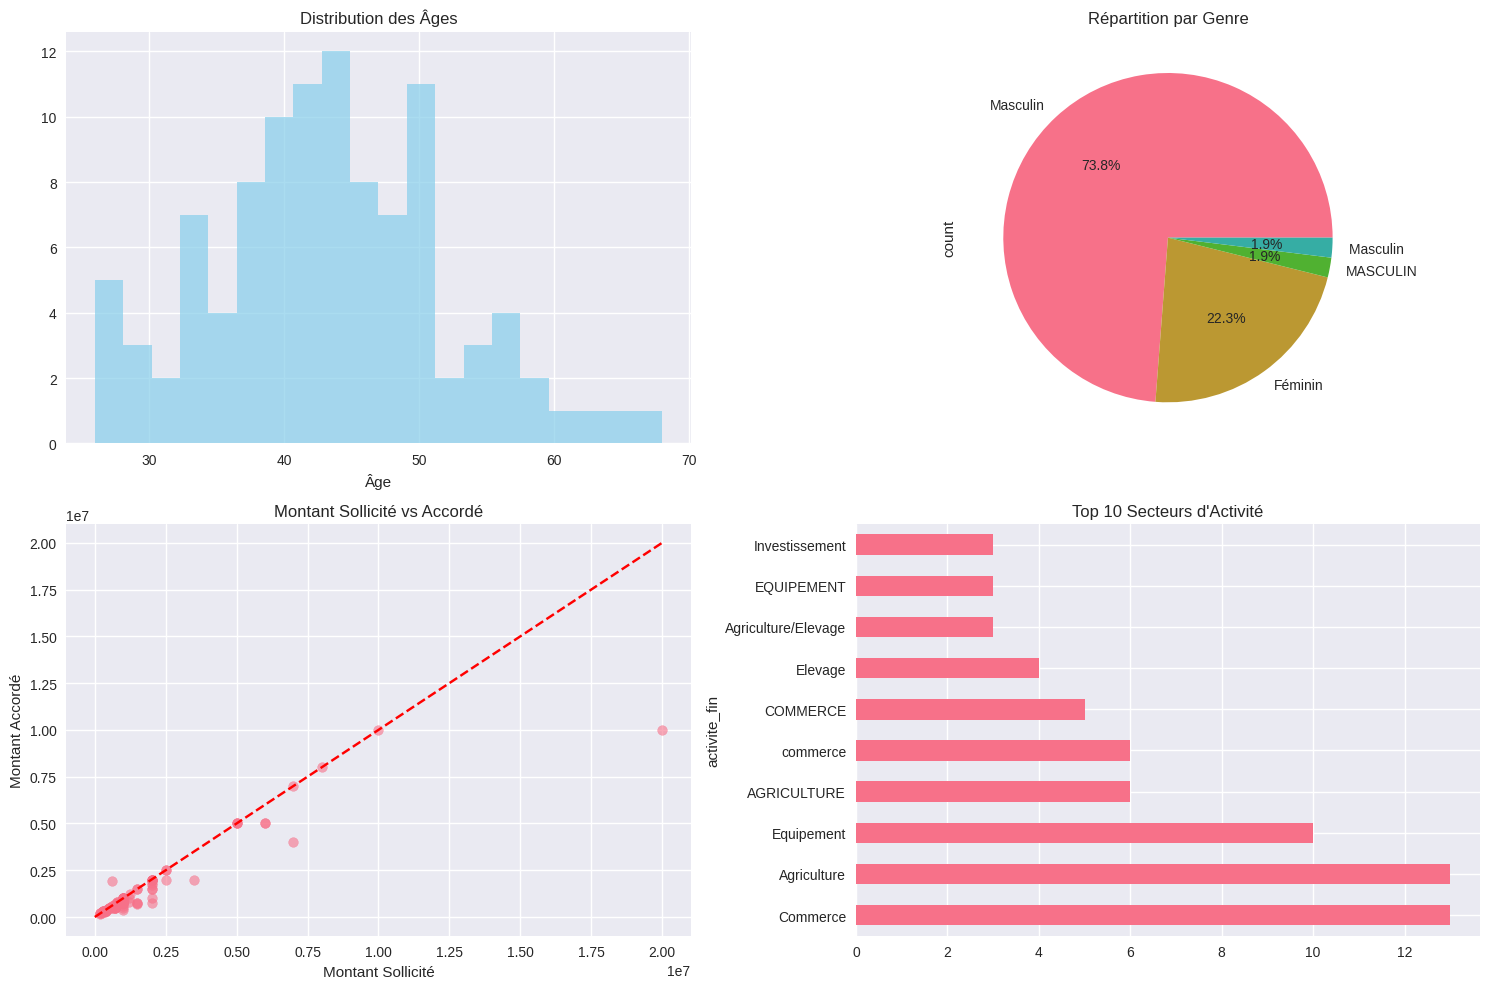


🧹 NETTOYAGE DES DONNÉES
✅ Dataset nettoyé: 103 lignes conservées

⚙️ INGÉNIERIE DES FEATURES
✅ 5 variables encodées
✅ 6 nouvelles features créées

🎯 ENTRAÎNEMENT DES MODÈLES OPTIMISÉS
🔄 Optimisation du modèle de statut...
✅ Meilleurs paramètres statut: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

📊 ÉVALUATION DES PERFORMANCES
🎯 Accuracy: 0.857
🎯 Cross-validation moyenne: 0.857 (+/- 0.233)


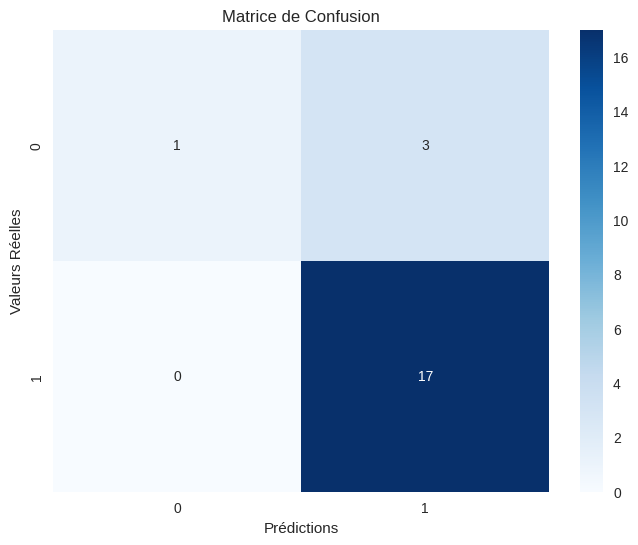


📋 Rapport de Classification:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.85      1.00      0.92        17

    accuracy                           0.86        21
   macro avg       0.93      0.62      0.66        21
weighted avg       0.88      0.86      0.82        21


🔍 TOP 10 FEATURES LES PLUS IMPORTANTES:
activite_fin_encoded: 0.139
ratio_besoin_demande: 0.112
score_risque: 0.089
ratio_fond_roul: 0.075
eval_besoin_fin: 0.074
ratio_client: 0.055
charge_par_personne: 0.046
mont_moy_ant: 0.042
mont_sollic: 0.040
ratio_rotsock: 0.037


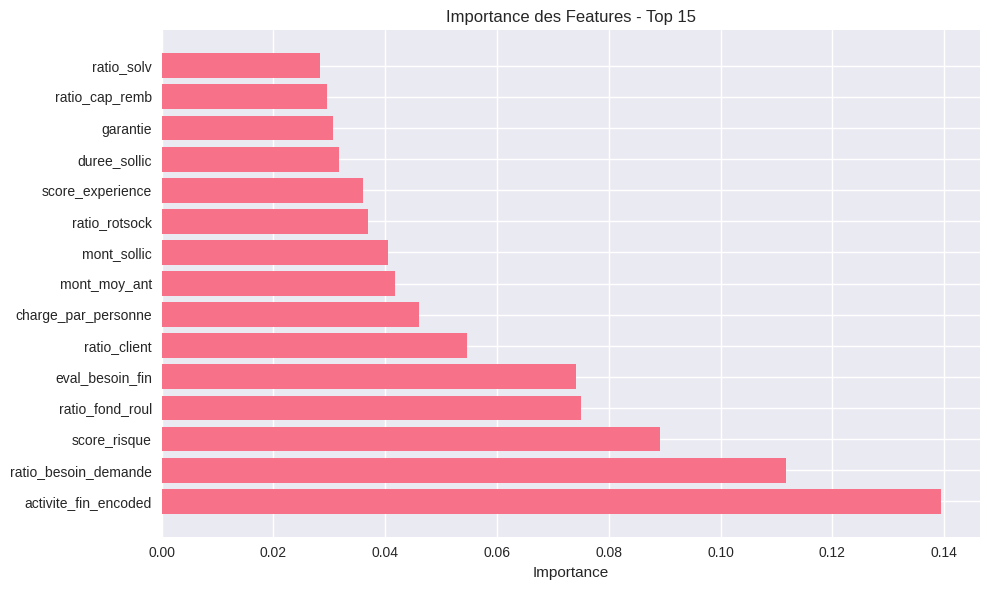


🔮 TEST DE PRÉDICTION
Résultat: {'statut': 'Accordé', 'probabilite_accord': 0.78, 'confiance': 'Moyenne', 'montant_accorde': 796000, 'duree_mois': 12, 'periodicite': 'Mensuelle'}
✅ Modèle sauvegardé: modele_credit_kaggle.pkl
💾 Téléchargez ce fichier pour l'utiliser dans votre application web

🎉 ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!
📁 Téléchargez le fichier .pkl pour votre application web


In [39]:
def main():
    """Pipeline principal d'entraînement"""
    
    # 1. Chargement des données
    conn = charger_donnees_sql()
    df = extraire_dataframe(conn)
    
    # 2. Exploration
    df = explorer_donnees(df)
    
    # 3. Nettoyage
    df_clean = nettoyer_donnees(df)
    
    # 4. Ingénierie des features
    df_features, encoders = ingenierie_features(df_clean)
    
    # 5. Modélisation
    model = CreditMLModel()
    model.encoders = encoders
    
    X = model.preparer_features(df_features)
    X_test, y_test = model.entrainer_modeles_optimises(X, df_features)
    
    # 6. Évaluation
    model.evaluer_performance(X_test, y_test)
    
    # 7. Test de prédiction
    print("\n🔮 TEST DE PRÉDICTION")
    exemple = {
        'age': 35, 'sexe_encoded': 1, 'nb_pers_charg': 3,
        'eval_besoin_fin': 800000, 'activite_fin_encoded': 2,
        'duree_sollic': 12, 'mont_sollic': 1000000,
        'periodicite_encoded': 1, 'nbr_cred_ant': 2,
        'mont_moy_ant': 500000, 'garantie': 2000000,
        'ratio_fond_roul': 500, 'ratio_client': 400,
        'ratio_solv': 300, 'ratio_rotsock': 0.5,
        'ratio_cap_remb': 5.0, 'ratio_demande_garantie': 0.5,
        'charge_par_personne': 250000, 'score_experience': 1.0,
        'ratio_besoin_demande': 0.8, 'categorie_age_encoded': 1,
        'score_risque': 2.5
    }
    
    prediction = model.predire(exemple)
    print(f"Résultat: {prediction}")
    
    # 8. Sauvegarde
    model.sauvegarder()
    
    print("\n🎉 ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
    print("📁 Téléchargez le fichier .pkl pour votre application web")

    return model

# Exécution
if __name__ == "__main__":
    modele_final = main()